In [ ]:
1-1 

In [ ]:
import time
import cv2
import glob
import os
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.svm import LinearSVC
import os
import shutil
from google.colab import drive
drive.mount('/content/data')        #구글드라이브를 content폴더에 마운팅

#from google.colab import files 
start_time = time.time()

'''
Parameters
'''
patch_stride = 16
K = 20

'''
Load Dataset
(don't modify)
Coast, Forest, Mountain, OpenCountry, Tallbuilding사용
'''
def scene15():
    train_folders = glob.glob("./data/MyDrive/data/SCENE15/train/*") #로딩된 구글드라이브중에 파일 마운팅
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./data/MyDrive/data/SCENE15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train)[random_indices].tolist()
y_train = np.array(y_train)[random_indices].tolist()

'''
Extract Patches
(don't modify)
'''
x_train = [np.array(image) for image in x_train] #image.shape적용을 위해 numpy로변환

train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), len(range(0, h, patch_stride))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), len(range(0, h, patch_stride))))

'''
P-1.1
''' 
descriptor = cv2.SIFT_create()  # Define your descriptor

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    # 이미지가 그레이스케일이 아닌 경우 그레이스케일로 변환
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이미지가 8비트가 아닌 경우 8비트로 변환
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    _, features = descriptor.compute(image, key_points)
    train_features.append(features)

    # 특징 출력
    print(f"Image {index+1} - Features:")
    print(features)  # 각 키포인트의 특징 벡터 출력
    print(f"Number of keypoints: {len(key_points)}")
    print(f"Feature dimensions: {features.shape}")

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    ######## Write Your Code Here ##########
    _, features = descriptor.compute(image, key_points)
    ########################################
    test_features.append(features)
    index += 1
    print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

for image, key_points in zip(x_test, test_key_points):
    # 이미지가 그레이스케일이 아닌 경우 그레이스케일로 변환
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이미지가 8비트가 아닌 경우 8비트로 변환
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    _, features = descriptor.compute(image, key_points)
    test_features.append(features)

    # 특징 출력
    print(f"Test Image {index+1} - Features:")
    print(features)  # 각 키포인트의 특징 벡터 출력
    print(f"Number of keypoints: {len(key_points)}")
    print(f"Feature dimensions: {features.shape}")
'''
Normalizing
(don't modify)
'''
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
    print(features)  # 정규화된 특징 벡터 출력
    print(f"Shape of normalized features: {features.shape}")  # 특징 벡터의 크기 출력

test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))
    print(features)  # 정규화된 특징 벡터 출력
    print(f"Shape of normalized features: {features.shape}")  # 특징 벡터의 크기 출력


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [ 0.5997218   2.2583847   0.9995785  ...  1.2450142  -1.5514274
   0.4943602 ]
 [ 0.57965964  2.051292    0.8907562  ...  1.0499473  -0.33668402
   1.6700213 ]]
Shape of normalized features: (256, 128)
Normalize Test Features ...   68/ 400
[[ 0.84289706 -1.2927432  -1.7823174  ...  0.92860967 -0.05165445
  -1.1113075 ]
 [ 0.42992803 -0.64923066 -2.1553478  ...  2.8772871   1.5090363
  -0.64509   ]
 [-0.10270438 -0.01560477 -2.3399012  ... -1.2010653  -1.7100536
   3.4340222 ]
 ...
 [ 0.98869324  0.83081126  1.9415262  ... -0.85951906  0.83044654
  -0.8698393 ]
 [ 0.86155665  1.2667419   1.8814962  ...  0.06143469  0.36614174
   0.5870919 ]
 [ 0.550954    1.8692483   1.6547058  ... -0.43399537 -0.4729204
  -0.30056635]]
Shape of normalized features: (256, 128)
Normalize Test Features ...   69/ 400
[[ 1.3675605  -1.16858    -1.175511   ... -2.1253064  -1.1752975
   0.81796837]
 [ 1.456396   -0.63947517 -1.493816   ...  0.49077263  0.61244595
   0.0812

1-2 

In [ ]:
 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import AdditiveChi2Sampler

class Codebook:

    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, verbose=True)

    def make_code_words(self, features):
        # K-means 알고리즘으로 codewords(centroids)를 생성합니다.
        self.kmeans.fit(features)

    def encode(self, features, shapes):
        # centroids와 각 feature 간의 거리를 계산합니다.
        distances = self.kmeans.transform(features)
        # 각 이미지에 대해 히스토그램을 초기화합니다.
        representations = np.zeros((shapes[0], self.K), dtype=np.int64)

        # distances를 사용하여 각 feature를 가장 가까운 centroid로 매핑합니다.
        nearest_centroids = np.argmin(distances, axis=1)  # 가장 가까운 centroid의 인덱스를 찾음
        for idx in nearest_centroids:
            representations[0, idx] += 1  # 해당 centroid의 bin을 증가시킴

        # 히스토그램을 정규화합니다. (선택 사항, Bag-of-Features에서 자주 사용)
        representations = representations / np.sum(representations, axis=1, keepdims=True)

        # representations의 차원이 올바른지 확인
        if np.array(representations).shape[1] != self.K:
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

'''
Encode Codebook and encoded features
(Don't modify)
'''
### CODE BOOK Make ####
print("Make Codebook ...")
#flattened_train_features : PCA로 변환된 학습 데이터 (1-1에서 만든것 ###)
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

def handle_nan_features(features):
    """
    NaN 값을 처리하는 함수. NaN을 0으로 대체하거나 필요 시 다른 방식으로 처리 가능.
    """
    features = np.nan_to_num(features, nan=0.0)  # NaN 값을 0으로 대체
    return features

train_encoded_features = []
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode(features, shapes)
    encoded_features = handle_nan_features(encoded_features)  # NaN 값 처리
    train_encoded_features.append(encoded_features.flatten())  # 2차원으로 변환
    index += 1
    print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))

test_encoded_features = []
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode(features, shapes)
    encoded_features = handle_nan_features(encoded_features)  # NaN 값 처리
    test_encoded_features.append(encoded_features.flatten())  # 2차원으로 변환
    index += 1
    print("Encoding Test Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))


'''
Approximate Kernel for encoded features
(Don't modify)
'''
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
print("train_encoded_features ...")
print(train_encoded_features)
print("test_encoded_features ...")
print(train_encoded_features)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)
print("chi2sampler train_encoded_features ...")
print(train_encoded_features)
print("chi2sampler test_encoded_features ...")
print(train_encoded_features)

Make Codebook ...
Initialization complete
Iteration 0, inertia 8062548.0.
Iteration 1, inertia 6313254.5.
Iteration 2, inertia 6224902.0.
Iteration 3, inertia 6181952.5.
Iteration 4, inertia 6161056.5.
Iteration 5, inertia 6148252.5.
Iteration 6, inertia 6138299.0.
Iteration 7, inertia 6130245.0.
Iteration 8, inertia 6124512.5.
Iteration 9, inertia 6120847.0.
Iteration 10, inertia 6118515.0.
Iteration 11, inertia 6116818.5.
Iteration 12, inertia 6115311.5.
Iteration 13, inertia 6114266.5.
Iteration 14, inertia 6113550.5.
Iteration 15, inertia 6113039.5.
Iteration 16, inertia 6112765.0.
Iteration 17, inertia 6112554.0.
Iteration 18, inertia 6112363.0.
Iteration 19, inertia 6112282.0.
Iteration 20, inertia 6112194.5.
Iteration 21, inertia 6112135.5.
Iteration 22, inertia 6112143.5.
Iteration 23, inertia 6112105.0.
Iteration 24, inertia 6112064.0.
Iteration 25, inertia 6112055.5.
Iteration 26, inertia 6112026.0.
Iteration 27, inertia 6111970.5.
Iteration 28, inertia 6111956.5.
Iteration 2

<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(re

Encoding Train Features ...   17/ 200
Encoding Train Features ...   18/ 200
Encoding Train Features ...   19/ 200
Encoding Train Features ...   20/ 200
Encoding Train Features ...   21/ 200
Encoding Train Features ...   22/ 200
Encoding Train Features ...   23/ 200
Encoding Train Features ...   24/ 200
Encoding Train Features ...   25/ 200
Encoding Train Features ...   26/ 200
Encoding Train Features ...   27/ 200
Encoding Train Features ...   28/ 200
Encoding Train Features ...   29/ 200
Encoding Train Features ...   30/ 200
Encoding Train Features ...   31/ 200
Encoding Train Features ...   32/ 200
Encoding Train Features ...   33/ 200
Encoding Train Features ...   34/ 200
Encoding Train Features ...   35/ 200
Encoding Train Features ...   36/ 200
Encoding Train Features ...   37/ 200
Encoding Train Features ...   38/ 200
Encoding Train Features ...   39/ 200
Encoding Train Features ...   40/ 200
Encoding Train Features ...   41/ 200
Encoding Train Features ...   42/ 200
Encoding Tra

<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(re

Encoding Train Features ...   98/ 200
Encoding Train Features ...   99/ 200
Encoding Train Features ...  100/ 200
Encoding Train Features ...  101/ 200
Encoding Train Features ...  102/ 200
Encoding Train Features ...  103/ 200
Encoding Train Features ...  104/ 200
Encoding Train Features ...  105/ 200
Encoding Train Features ...  106/ 200
Encoding Train Features ...  107/ 200
Encoding Train Features ...  108/ 200
Encoding Train Features ...  109/ 200
Encoding Train Features ...  110/ 200
Encoding Train Features ...  111/ 200
Encoding Train Features ...  112/ 200
Encoding Train Features ...  113/ 200
Encoding Train Features ...  114/ 200
Encoding Train Features ...  115/ 200
Encoding Train Features ...  116/ 200
Encoding Train Features ...  117/ 200
Encoding Train Features ...  118/ 200
Encoding Train Features ...  119/ 200
Encoding Train Features ...  120/ 200
Encoding Train Features ...  121/ 200
Encoding Train Features ...  122/ 200
Encoding Train Features ...  123/ 200
Encoding Tra

<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(re

Encoding Train Features ...  183/ 200
Encoding Train Features ...  184/ 200
Encoding Train Features ...  185/ 200
Encoding Train Features ...  186/ 200
Encoding Train Features ...  187/ 200
Encoding Train Features ...  188/ 200
Encoding Train Features ...  189/ 200
Encoding Train Features ...  190/ 200
Encoding Train Features ...  191/ 200
Encoding Train Features ...  192/ 200
Encoding Train Features ...  193/ 200
Encoding Train Features ...  194/ 200
Encoding Train Features ...  195/ 200
Encoding Train Features ...  196/ 200
Encoding Train Features ...  197/ 200
Encoding Train Features ...  198/ 200
Encoding Train Features ...  199/ 200
Encoding Train Features ...  200/ 200
Encoding Test Features ...    1/ 400
Encoding Test Features ...    2/ 400
Encoding Test Features ...    3/ 400
Encoding Test Features ...    4/ 400
Encoding Test Features ...    5/ 400
Encoding Test Features ...    6/ 400
Encoding Test Features ...    7/ 400
Encoding Test Features ...    8/ 400
Encoding Test Featur

<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(re

Encoding Test Features ...   60/ 400
Encoding Test Features ...   61/ 400
Encoding Test Features ...   62/ 400
Encoding Test Features ...   63/ 400
Encoding Test Features ...   64/ 400
Encoding Test Features ...   65/ 400
Encoding Test Features ...   66/ 400
Encoding Test Features ...   67/ 400
Encoding Test Features ...   68/ 400
Encoding Test Features ...   69/ 400
Encoding Test Features ...   70/ 400
Encoding Test Features ...   71/ 400
Encoding Test Features ...   72/ 400
Encoding Test Features ...   73/ 400
Encoding Test Features ...   74/ 400
Encoding Test Features ...   75/ 400
Encoding Test Features ...   76/ 400
Encoding Test Features ...   77/ 400
Encoding Test Features ...   78/ 400
Encoding Test Features ...   79/ 400
Encoding Test Features ...   80/ 400
Encoding Test Features ...   81/ 400
Encoding Test Features ...   82/ 400
Encoding Test Features ...   83/ 400
Encoding Test Features ...   84/ 400
Encoding Test Features ...   85/ 400
Encoding Test Features ...   86/ 400
E

<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(representations, axis=1, keepdims=True)
<ipython-input-21-0e4dc64a9d11>:36: RuntimeWarning: invalid value encountered in divide
  representations = representations / np.sum(re

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.046875  , 0.0078125 , 0.04296875, 0.01171875, 0.0703125 ,
       0.04296875, 0.13671875, 0.0234375 , 0.06640625, 0.01953125,
       0.1015625 , 0.08984375, 0.06640625, 0.0390625 , 0.02734375,
       0.1015625 , 0.03125   , 0.03515625, 0.01171875, 0.02734375,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.   

1-3 

Classify Images ...
[LibLinear]
Train  Score: 0.86667
Test   Score: 0.80400
Elapsed Time: 178.76 secs


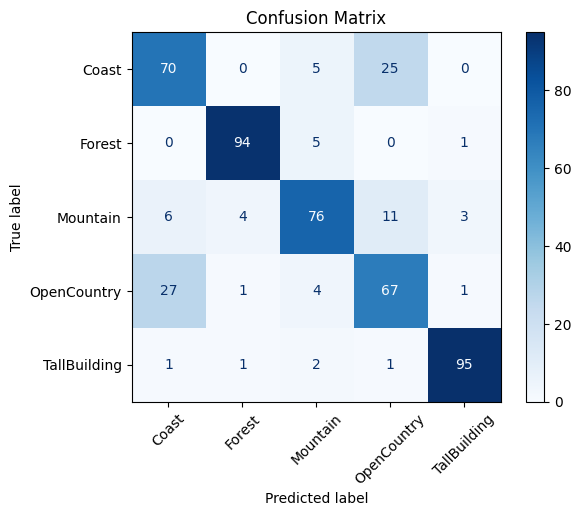

In [ ]:


###############1-3

from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

'''
P-1.3 : Classify Images with SVM
'''

# SVM 모델 정의
# parameter 값을 수정해가면서 성능향상을 시도
model = LinearSVC(C=1.0, max_iter=1000, verbose=True)

print("Classify Images ...")

# Bag-of-Features로 생성된 Train/Test Encoded Features 사용
X_train = np.vstack(train_encoded_features)  # Train Encoded Features
X_test = np.vstack(test_encoded_features)    # Test Encoded Features

# SVM 학습
model.fit(X_train, y_train)

# 학습 및 테스트 정확도 계산
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

elapsed_time = time.time() - start_time

'''
Print Results
'''
print()
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

'''
Confusion Matrix
'''
# 예측값 생성
y_pred = model.predict(X_test)

# Confusion Matrix 생성
Confusion_Matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=Confusion_Matrix, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
